In [2]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from pylab import cm
import warnings

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import qiskit
from qiskit import *
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer

from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List

#define utility functions

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(2,20):
        assert counter[i]==0
        
    return counter

In [2]:
# #load the mock data (for testing only)
# files=os.listdir("mock_data")
# dataset=list()
# for file in files:
#     with open('mock_data/'+file, "r") as infile:
#         loaded = json.load(infile)
#         dataset.append(loaded)

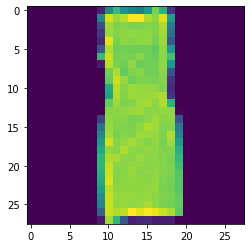

In [3]:
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
#you can visualize it
import matplotlib.pyplot as plt
plt.imshow(images[1100])

In [8]:
#your submission

# Functions 'encode' and 'decode' are dummy.
def encode(image):
    print("Encoding...")
    number_of_qubits = math.ceil(math.log(28*28, 2))
    amplitude_vector = [0] * (2**number_of_qubits)
    sum_squares = 0
    amplitude_counter = 0
    for i in image:
        for j in i:
            sum_squares+=j**2
            amplitude_vector[amplitude_counter] = j
            amplitude_counter+=1
    global norm
    norm = 1/np.sqrt(sum_squares)
    amplitude_vector_new = [i*norm for i in amplitude_vector]
    
    # Some previous tests we were running -- ignore
    
    # global imtest
    # imtest=[[0]*28 for z in range(28)]
    # a_counter=0
    # for i in range(28):
    #     for j in range(28):
    #         imtest[i][j]=amplitude_vector[a_counter]#/norm
    #         a_counter+=1
            
            
    # print(amplitude_vector)
    qr = qiskit.QuantumRegister(number_of_qubits)
    qc = qiskit.QuantumCircuit(qr)
    qc.initialize(amplitude_vector_new, qr)

    print("Encoded!")
    return qc

def decode(histogram):
    print("Decoding...")      
    image = [[0] * 28 for z in range(28)]
    amplitude_counter=1
    for i in range(28):
        for j in range(28):
            image[i][j] = histogram.get(amplitude_counter, 0)#/norm
            amplitude_counter+=1
    print("Decoded!")
    return image

def run_part1(image):
    #encode image into a circuit
    circuit=encode(image)

    #simulate circuit
    histogram=simulate(circuit)

    #reconstruct the image
    image_re=decode(histogram)

    return circuit,image_re


def run_part2(image):
    # load the quantum classifier circuit
    # classifier=qiskit.QuantumCircuit.from_qasm_file('quantum_classifier.qasm')
    
    #encode image into circuit
    circuit = encode(image)
    image = decode(simulate(circuit))
    
    nsamples, nx, ny = image.shape
    images_reshaped = image.reshape((nsamples,nx*ny))
    
    
    
    
    #append with classifier circuit
    # nq1 = circuit.width()
    # nq2 = classifier.width()
    # nq = max(nq1, nq2)
    # qc = qiskit.QuantumCircuit(nq)
    # qc.append(circuit.to_instruction(), list(range(nq1)))
    # qc.append(classifier.to_instruction(), list(range(nq2)))
    
    
    
    #simulate circuit
    histogram=simulate(qc)
        
    #convert histogram to category
    label=histogram_to_category(histogram)
    
    #thresholding the label, any way you want
    if label>0.5:
        label=1
    else:
        label=0
        
    return circuit,label
        
    return circuit,label


#score

In [10]:
#how we grade your submission

score=0
gatecount=0
n=len(dataset)

for data in dataset:
    #run part 2
    circuit,label=run_part2(data['image'])
    
    #count the gate used in the circuit for score calculation
    gatecount+=count_gates(circuit)[2]
    
    #check label
    if label==data['category']:
        score+=1
#score
score=score/n
gatecount=gatecount/n

print(score*(0.999**gatecount))

1.0


ValueError: not enough values to unpack (expected 3, got 2)

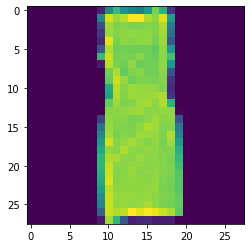

In [89]:
new_array=np.zeros((2000, 764))
img_counter = 0
pxl_counter = 0
for image in images:
    image_array = np.zeros((764))
    for i in image:
        for j in i:
            image_array[pxl_counter] = j
            pxl_counter += 1
        pxl_counter = 0
    new_array[img_counter] = image_array
    img_counter += 1

In [90]:
nsamples, nx, ny = images.shape
images_reshaped = images.reshape((nsamples,nx*ny))

In [91]:
# training quantum classifier
train_images, test_images, train_labels, test_labels = train_test_split(
    images_reshaped, labels, test_size=0.2, random_state=420)

sample_train, sample_val, labels_train, labels_val = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42)

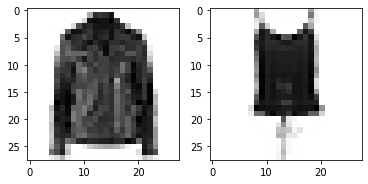

In [92]:
fig = plt.figure()
LABELS = [0, 1]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(1, num_labels, i+1)
    img = train_images[train_labels==LABELS[i]][0].reshape((28, 28))
    ax.imshow(img, cmap="Greys")

In [93]:
print(train_images.shape)

(1600, 784)


In [94]:
# # sample_train = train_images
# # sample_val = test_images
# # labels_train = train_labels
# # labels_val = test_labels

In [95]:
# Standardize
standard_scaler = StandardScaler()
sample_train = standard_scaler.fit_transform(sample_train)
sample_val = standard_scaler.transform(sample_val)
test_images = standard_scaler.transform(test_images)

# Reduce dimensions
N_DIM = 5
pca = PCA(n_components=N_DIM)
sample_train = pca.fit_transform(sample_train)
sample_val = pca.transform(sample_val)
test_images = pca.transform(test_images)

# Normalize
min_max_scaler = MinMaxScaler((-1, 1))
sample_train = min_max_scaler.fit_transform(sample_train)
sample_val = min_max_scaler.transform(sample_val)
test_images = min_max_scaler.transform(test_images)

In [97]:
print(sample_train.shape)

(1280, 5)


In [98]:
labels_train_0 = np.where(labels_train==0, 1, 0)
labels_val_0 = np.where(labels_val==0, 1, 0)

print(f'Original validation labels:      {labels_val}')
print(f'Validation labels for 0 vs Rest: {labels_val_0}')

Original validation labels:      [False False  True False False False  True False False  True False False
 False  True False False  True False False False False False  True False
 False False False False False False False False  True False False False
  True  True False  True False False False False  True False False False
 False False False False False  True False False False False  True  True
 False False False False False  True False  True  True False  True False
 False False False False False False False  True False  True False  True
 False False False False False False  True False False False False  True
 False False  True False False False False False False False  True False
 False False False False False False False False False  True False False
 False  True False False False False False False False  True False False
 False  True False False False False False  True False False False  True
 False  True False  True False False False False False False False False
  True False False

In [99]:
pauli_map_0 = PauliFeatureMap(feature_dimension=N_DIM, reps=2, paulis = ['X', 'Y', 'ZZ'])
pauli_kernel_0 = QuantumKernel(feature_map=pauli_map_0, quantum_instance=Aer.get_backend('statevector_simulator'))

pauli_svc_0 = SVC(kernel='precomputed', probability=True)

matrix_train_0 = pauli_kernel_0.evaluate(x_vec=sample_train)
pauli_svc_0.fit(matrix_train_0, labels_train_0)

matrix_val_0 = pauli_kernel_0.evaluate(x_vec=sample_val, y_vec=sample_train)
pauli_score_0 = pauli_svc_0.score(matrix_val_0, labels_val_0)
print(f'Accuracy of discriminating between label 0 and others: {pauli_score_0*100}%')

Accuracy of discriminating between label 0 and others: 88.75%


In [100]:
matrix_test_0 = pauli_kernel_0.evaluate(x_vec=test_images, y_vec=sample_train)
pred_0 = pauli_svc_0.predict_proba(matrix_test_0)[:, 1]
print(f'Probability of label 0: {np.round(pred_0, 2)}')

Probability of label 0: [0.97 0.99 0.9  0.82 0.11 0.4  0.29 0.89 0.88 0.96 0.01 0.09 0.03 0.96
 0.92 0.21 0.9  0.98 0.43 0.38 0.9  0.69 0.99 0.07 0.94 0.98 0.03 0.91
 0.96 0.94 0.64 0.59 0.76 0.83 0.01 0.91 0.06 0.84 0.88 0.14 0.75 0.48
 0.88 0.96 0.84 0.96 0.97 0.84 0.76 0.39 0.01 0.23 0.87 0.83 0.87 0.9
 0.62 0.99 0.98 0.24 1.   0.03 0.96 0.69 0.89 0.96 0.83 0.96 0.96 0.91
 0.97 0.98 0.94 0.11 0.87 0.93 0.86 0.9  0.9  0.72 0.44 0.99 0.49 0.51
 0.51 0.96 0.04 0.65 0.9  0.76 0.14 0.92 0.86 0.98 0.97 0.99 0.98 0.9
 0.06 0.12 0.72 0.99 0.99 0.78 0.71 0.99 0.9  0.85 0.71 0.64 0.9  0.99
 0.98 0.24 0.83 0.97 0.98 0.81 0.78 0.14 0.99 0.39 0.5  0.86 0.92 0.21
 0.63 0.46 0.98 0.98 0.98 0.85 0.16 0.52 0.95 0.95 0.88 0.02 0.91 0.07
 0.86 0.96 0.91 0.98 0.99 0.92 0.78 0.85 0.99 0.92 0.85 0.63 0.96 0.92
 0.95 0.78 0.02 0.98 0.94 0.51 0.12 0.84 0.19 0.98 0.98 0.82 0.12 0.98
 0.9  0.02 0.98 0.97 0.99 0.97 0.94 0.03 0.97 0.31 0.96 0.62 0.95 0.99
 0.99 0.02 0.94 0.95 0.91 0.02 0.92 0.91 0.87 0.99 0.96

In [105]:
pred = pauli_svc_0.predict_proba(matrix_test_0)[4]

[0.88862201 0.11137799]


In [109]:
classifier_file = open('quantum_classifier.pickle', 'wb')
pickle.dump(pauli_kernel_0, classifier_file)
classifier_file.close()

In [ ]:
matrix_test_0 = pauli_kernel_0.evaluate(x_vec=images_reshaped)
pred = pauli_svc_0.predict_proba(images)[0]
print(pred)